In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Num GPUs Available:  2
2 Physical GPUs, 2 Logical GPUs


In [2]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping
# from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from matplotlib import pyplot

# example of preparing the horses and zebra dataset
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
autotune = tf.data.experimental.AUTOTUNE
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
train_dir = '/home/mikylab/cycleGan/melanomaImages/train/'
MSKCC_csv = pd.read_csv('/home/mikylab/cycleGan/clinic_csv/MSKCC_contribution.csv')
MSKCC_frame = pd.DataFrame({'image_dir': MSKCC_csv['name'], 'target': MSKCC_csv['meta.clinical.benign_malignant']})
MSKCC_frame.target[MSKCC_frame.target == 'benign'] = 0
MSKCC_frame.target[MSKCC_frame.target == 'malignant'] = 1
MSKCC_frame.target = MSKCC_frame.target.apply(int)
MSKCC_mal_train = MSKCC_frame[MSKCC_frame['target']==1]
MSKCC_ben_train = MSKCC_frame[MSKCC_frame['target']==0].sample(n=500, random_state = 316)
MSKCC_frame =  pd.concat([MSKCC_mal_train, MSKCC_ben_train], ignore_index=True, sort =False)
#MSKCC_frame['image_dir'] = train_dir + MSKCC_frame['image_dir'] + '.jpg'
MSKCC_frame['image_dir'] = MSKCC_frame['image_dir'] + '.jpg'


In [4]:
BCN_csv = pd.read_csv('/home/mikylab/cycleGan/clinic_csv/BCN_contribution.csv')
BCN_frame = pd.DataFrame({'image_dir': BCN_csv['name'], 'target': BCN_csv['meta.clinical.benign_malignant']})
BCN_frame.target[BCN_frame.target == 'benign'] = 0
BCN_frame.target[BCN_frame.target == 'malignant'] = 1
BCN_frame.target = BCN_frame.target.apply(int)

BCN_mal_train = BCN_frame[BCN_frame['target']==1]
BCN_ben_train = BCN_frame[BCN_frame['target']==0].sample(n=500, random_state = 316)
BCN_frame =  pd.concat([BCN_mal_train, BCN_ben_train], ignore_index=True, sort =False)

In [5]:
BCN_frame['image_dir'] = BCN_frame['image_dir'] + '.jpg'

In [6]:
# from sklearn.model_selection import train_test_split
# x_train, x_val, y_train, y_val = train_test_split(MSKCC_frame['image_dir'], MSKCC_frame['target'], test_size = 0.2, shuffle = True, random_state = 316)
# train_A = pd.DataFrame({'image_dir': x_train, 'target': y_train})
# test_A = pd.DataFrame({'image_dir': x_val, 'target': y_val})

In [7]:
# x_train, x_val, y_train, y_val = train_test_split(BCN_frame['image_dir'], BCN_frame['target'], test_size = 0.2, shuffle = True, random_state = 316)
# train_B = pd.DataFrame({'image_dir': x_train, 'target': y_train})
# test_B = pd.DataFrame({'image_dir': x_val, 'target': y_val})

In [8]:
train_A = pd.read_csv('train_MSKCC.csv')
test_A = pd.read_csv('test_MSKCC.csv')

train_B = pd.read_csv('train_BCN.csv')
test_B = pd.read_csv('test_BCN.csv')

In [9]:
# trainA_images = train_A['image_dir'].to_numpy()

In [10]:
# trainA_images

In [11]:
def show_img_gen(generator, color):
    for i in range(0,1):
        image = generator[i] 
        if (color == "grayscale"):
            newimage = reshape(image,(256,256))
            plt.imshow(newimage, cmap = 'gray')
            plt.colorbar()
        elif (color == "color"):
            print(image[0][0,:, :].shape)
            plt.imshow(image[0][0,:, :])
            plt.colorbar()
# show_img_gen(MSKCC_data_test, 'color')

In [12]:
test_A['image_dir'].shape

(2742,)

In [13]:
# # load all images in a directory into memory
def load_images(path, image_list, size=(256,256)):
    data_list = list()
    # enumerate filenames in directory, assume all are images
    for filename in image_list:
        # load and resize the image
        pixels = load_img(path + filename + '.jpg', target_size=size)
        # convert to numpy array
        pixels = img_to_array(pixels)
        # store
        data_list.append(pixels)
    return asarray(data_list)


# dataset path
# path = '/home/mikylab/datasets/cycleGan/'
path = '/home/mikylab/cycleGan/melanomaImages/train/'

# # load dataset train images 
# dataA1 = load_images(path, train_A['image_dir'].to_numpy())
# dataA2 = load_images(path, test_A['image_dir'].to_numpy())
# dataA = vstack((dataA1, dataA2))
# print('Loaded dataA: ', dataA.shape)
# # load dataset test_2016 images
# dataB1 = load_images(path, train_B['image_dir'].to_numpy())
# dataB2 = load_images(path, test_B['image_dir'].to_numpy())
# dataB = vstack((dataB1, dataB2))
# print('Loaded dataB: ', dataB.shape)
# # save as compressed numpy array
# filename = 'cycleGan.npz'
# savez_compressed(filename, dataA1, dataA2, dataB1, dataB2)
# print('Saved dataset: ', filename)


In [14]:
dataset = np.load('cycleGan.npz')
dataA1, dataA2, dataB1, dataB2,  = dataset['arr_0'], dataset['arr_1'], dataset['arr_2'], dataset['arr_3']
print('Loaded: ', dataA1.shape, dataA2.shape)

Loaded:  (8366, 256, 256, 3) (2742, 256, 256, 3)


In [15]:
train_A.iloc[0]

image_dir    ISIC_3768701
target                  0
Name: 0, dtype: object

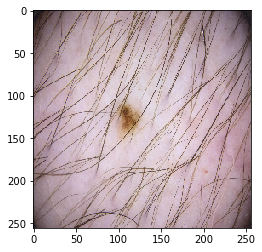

In [16]:
plt.imshow(dataA1[0]/255.)

In [17]:
# def get_groundTruth(csv, file_names):
#     csv_copy = csv
#     csv_copy.reset_index(drop= True, inplace= True)
#     filenames_dataframe = pd.DataFrame(file_names, columns = ['images'])
    
#     files_dataframe = filenames_dataframe.merge(csv_copy, left_on = "images", right_on = 'image_dir')
#     numpy_truth = files_dataframe['target'].to_numpy()
#     tensor_truth = tf.convert_to_tensor(numpy_truth)
#     return numpy_truth

# testA_ground_truth = get_groundTruth(test_A, dataA2_list)
# testB_ground_truth = get_groundTruth(test_B, dataB2_list)

In [18]:
testA_ground_truth = test_A['target'].to_numpy()
testB_ground_truth = test_B['target'].to_numpy()

In [19]:
# def get_dataframe(csv, file_names):
#     csv_copy = csv
#     csv_copy.reset_index(drop= True, inplace= True)
#     filenames_dataframe = pd.DataFrame(file_names, columns = ['images'])
    
#     files_dataframe = filenames_dataframe.merge(csv_copy, left_on = "images", right_on = 'image_dir')
#     numpy_truth = files_dataframe.loc[:,'image_dir':'target']
#     return numpy_truth

# csv_testA = get_dataframe(test_A, dataA2_list)
# csv_testB = get_dataframe(test_B, dataB2_list)

In [20]:
csv_testA = test_A
csv_testB = test_B

In [21]:
#csv_testA = testA_files.loc[:, 'image_dir': 'target']

In [22]:
trainA_dataset = tf.data.Dataset.from_tensor_slices(dataA1)

trainB_dataset = tf.data.Dataset.from_tensor_slices(dataB1)

testA_dataset = tf.data.Dataset.from_tensor_slices(dataA2)

testB_dataset = tf.data.Dataset.from_tensor_slices(dataB2)


In [23]:
# test = tf.math.argmin(dataB1[:, :, :, :])

In [24]:
# plt.imshow(test)
# image = dataA2[0, :, :, :]/255.
# plt.hist(image.ravel(), bins=256, range=(0.0, 1.0)) #calculating histogram
# plt.axis()

In [25]:
# image
# plt.imshow(image)

In [26]:
# # tf.reduce_mean(dataB1[:, :, :, 1])

In [27]:
from tensorflow import keras

# Define the standard image size.
orig_img_size = (256, 256)
# Size of the random crops to be used during training.
input_img_size = (256, 256, 3)
# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

buffer_size = 256
batch_size = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256


def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0

def preprocess_train_image(img):
    # Random flip
    img = tf.image.random_flip_left_right(img)
    # Resize to the original size first
    img = tf.image.resize(img, [*orig_img_size])
    # Random crop to 256X256
    img = tf.image.random_crop(img, size=[*input_img_size])
    # Normalize the pixel values in the range [-1, 1]
    img = normalize_img(img)
    return img


def preprocess_test_image(img):
    # Only resizing and normalization for the test images.
    img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
    img = normalize_img(img)
#     img = tf.image.rot90(img, k=3)
    return img

def random_jitter(image):
  # resizing to 286 x 286 x 3
    image = tf.image.resize(image, [286, 286],
    method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # randomly cropping to 256 x 256 x 3
    image = random_crop(image)

    # random mirroring
    image = tf.image.random_flip_left_right(image)

    return image

def random_crop(image):
    cropped_image = tf.image.random_crop(
    image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image

"""
## Create `Dataset` objects
"""


# Apply the preprocessing operations to the training data
trainA_data = (
    trainA_dataset.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)

trainB_data = (
    trainB_dataset.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)

trainA_data_unshuffled = (
    trainA_dataset.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    #.shuffle(buffer_size)
    .batch(batch_size)
)

trainB_data_unshuffled = (
    trainB_dataset.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    #.shuffle(buffer_size)
    .batch(batch_size)
)

# Apply the preprocessing operations to the test data
testA_data = (
    testA_dataset.map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
#     .shuffle(buffer_size)
    .batch(batch_size)
)

testA_data2 = (
    testA_dataset.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)

testA_data2 = (
    testA_dataset.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
#     .shuffle(buffer_size)
    .batch(batch_size)
)


testB_data = (
    testB_dataset.map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
#     .shuffle(buffer_size)
    .batch(batch_size)
)

# testB_data2 = (
#     testB_dataset.map(preprocess_train_image, num_parallel_calls=autotune)
#     .cache()
#     .shuffle(buffer_size)
#     .batch(batch_size)
# )

testB_data2 = (
    testB_dataset.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
#     .shuffle(buffer_size)
    .batch(batch_size)
)

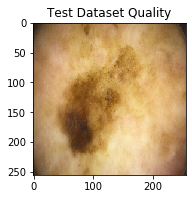

In [28]:
sample_train = next(iter(testA_data2))
sample_test = next(iter(testB_data2))

plt.subplot(121)
plt.title('Test Dataset Quality')
plt.imshow(sample_train[0] * 0.5 + 0.5)

# plt.subplot(122)
# plt.title('Testing Dataset Quality')
# plt.imshow(random_jitter(sample_train[0]) * 0.5 + 0.5)

In [29]:
testA_ground_truth

array([1, 1, 0, ..., 0, 0, 0])

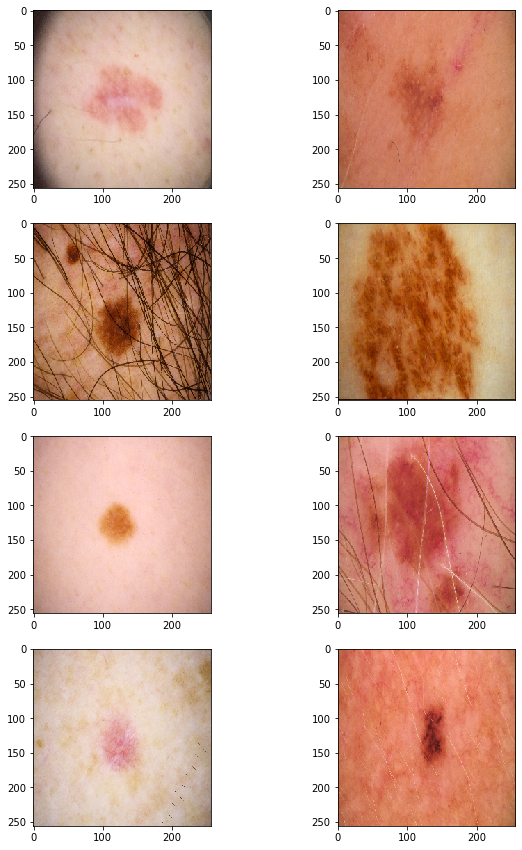

In [30]:
import numpy as np
import matplotlib.pyplot as plt
_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, samples in enumerate(zip(trainA_data.take(4), trainB_data.take(4))):
    a = (((samples[0][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    b = (((samples[1][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    ax[i, 0].imshow(a)
    ax[i, 1].imshow(b)
plt.show()

In [31]:
"""
## Building blocks used in the CycleGAN generators and discriminators
"""


class ReflectionPadding2D(layers.Layer):
    """Implements Reflection Padding as a layer.
    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.
    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = InstanceNormalization(axis=-1)(x)
    x = activation(x)
    #Dropout
    x = layers.Dropout(.5, seed = 316)(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = InstanceNormalization(axis=-1)(x)    
    x = layers.add([input_tensor, x])
    return x


def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x =  InstanceNormalization(axis=-1)(x)
    if activation:
        x = activation(x)
    return x


def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x =  InstanceNormalization(axis=-1)(x)
    if activation:
        x = activation(x)
    return x


"""
## Build the generators
The generator consists of downsampling blocks: nine residual blocks
and upsampling blocks. The structure of the generator is the following:
```
c7s1-64 ==> Conv block with `relu` activation, filter size of 7
d128 ====|
         |-> 2 downsampling blocks
d256 ====|
R256 ====|
R256     |
R256     |
R256     |
R256     |-> 9 residual blocks
R256     |
R256     |
R256     |
R256 ====|
u128 ====|
         |-> 2 upsampling blocks
u64  ====|
c7s1-3 => Last conv block with `tanh` activation, filter size of 7.
```
"""


def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    
    x =  InstanceNormalization(axis=-1)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model


"""
## Build the discriminators
The discriminators implement the following architecture:
`C64->C128->C256->C512`
"""


def get_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model


# Get the generators
gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")

# Get the discriminators
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")



In [32]:
def save_model(cycleGan, path):
    cycleGan.disc_Y.save(path + '/disc_Y')
    cycleGan.disc_X.save(path + '/disc_X')
    cycleGan.gen_F.save(path + '/gen_F')
    cycleGan.gen_G.save(path + '/gen_G')


In [33]:

"""
## Build the CycleGAN model
We will override the `train_step()` method of the `Model` class
for training via `fit()`.
"""

class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=.5,
    ):
        super(CycleGan, self).__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity
    def call (self, inputs):
        return 

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        ground_truth,
        classifier_model
        
    ):
        super(CycleGan, self).compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()
        
        self.ground_truth = ground_truth, 
        self.classifier_model = classifier_model 
        
    def train_step(self, batch_data):
        # x is dataA and y is dataB
        real_x, real_y, target_val = batch_data

        # For CycleGAN, we need to calculate different
        # kinds of losses for the generators and discriminators.
        # We will perform the following steps here:
        #
        # 1. Pass real images through the generators and get the generated images
        # 2. Pass the generated images back to the generators to check if we
        #    we can predict the original image from the generated image.
        # 3. Do an identity mapping of the real images using the generators.
        # 4. Pass the generated images in 1) to the corresponding discriminators.
        # 5. Calculate the generators total loss (adverserial + cycle + identity)
        # 6. Calculate the discriminators loss
        # 7. Update the weights of the generators
        # 8. Update the weights of the discriminators
        # 9. Return the losses in a dictionary
#         tf.print(self.classifier_model(real_x))

        with tf.GradientTape(persistent=True) as tape:
#             tf.print(real_x)
#             tf.print(target_val)
            # B to fake A
            fake_y = self.gen_G(real_x, training=True)
            # A to fake V -> y2x
            fake_x = self.gen_F(real_y, training=True)

            # Cycle (A to fake B to fake A): x -> y -> x
            cycled_x = self.gen_F(fake_y, training=True)
            # Cycle (B to fake A to fake B) y -> x -> y
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adverserial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )
            #Classification loss
            class_loss = tf.cast(target_val, tf.float32) - self.classifier_model(fake_x)
            class_loss = tf.math.abs(class_loss)
#             tf.print(class_loss)
            
#             tf.print(target_val)
#             tf.print(self.classifier_model(fake_x))
#             tf.print(tf.cast(target_val, tf.float32) - self.classifier_model(fake_x))
            

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G + class_loss
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F
#             tf.print(total_loss_G)

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }


"""
## Create a callback that periodically saves generated images
"""


class GANMonitor(keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=4):
        self.num_img = num_img
        
    def on_epoch_end(self, epoch, logs= None):
        save_model(self.model, 'cyclegan_model/8.16_MSKCC_to_MSKCC_constraints')

#     def on_epoch_end(self, epoch, logs=None):
#         #save_model(self.model, 'cyclegan_model/7.8')
#         _, ax = plt.subplots(4, 2, figsize=(12, 12))
#         for i, img in enumerate(testA_data2.take(self.num_img)):
# #             print(img)
#             prediction = self.model.gen_G(img)[0].numpy()
#             prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
#             img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

#             ax[i, 0].imshow(img)
#             ax[i, 1].imshow(prediction)
#             ax[i, 0].set_title("Input image")
#             ax[i, 1].set_title("Translated image")
#             ax[i, 0].axis("off")
#             ax[i, 1].axis("off")

#             prediction = keras.preprocessing.image.array_to_img(prediction)
# #             prediction.save(
# #                 "generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch + 1)
# #             )
#         plt.show()
#         plt.close()




In [34]:
"""
## Train the end-to-end model
"""

# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5





In [35]:
# Callbacks
plotter = GANMonitor()

In [36]:
testA_ground_truth =testA_ground_truth.astype('f')

In [37]:
# #Load classification model 
# load_model_MSKCC = tf.keras.models.load_model('models/cnn_melanoma_MSKCC_small_noweights_7.4.h5')

# #Load ground truth
# ground_truth_A = tf.data.Dataset.from_tensor_slices(testA_ground_truth)


# # Create cycle gan model
# cycle_gan_model = CycleGan(
#     generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
# )

# # Compile the model
# cycle_gan_model.compile(
#     gen_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
#     gen_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
#     disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
#     disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
#     gen_loss_fn=generator_loss_fn,
#     disc_loss_fn=discriminator_loss_fn,
#     ground_truth = ground_truth_A, 
#     classifier_model = load_model_MSKCC
# )

In [38]:
#Load classification model 
load_model_MSKCC = tf.keras.models.load_model('models/cnn_melanoma_MSKCC_small_noweights_7.4.h5')

#Load ground truth
ground_truth_A = tf.data.Dataset.from_tensor_slices(testA_ground_truth)

def load_model(path):
    discY = keras.models.load_model(path + '/disc_Y')
    discX = keras.models.load_model(path + '/disc_X')
    genF = keras.models.load_model(path + '/gen_F')
    genG = keras.models.load_model(path + '/gen_G')
    
    cycleGan_model = CycleGan(
        generator_G=genG, generator_F=genF, discriminator_X=discX, discriminator_Y=discY
    )

    # Compile the model
    cycleGan_model.compile(
        gen_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
        gen_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
        disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
        disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
        gen_loss_fn=generator_loss_fn,
        disc_loss_fn=discriminator_loss_fn,
        ground_truth = ground_truth_A, 
        classifier_model = load_model_MSKCC
    )
    return cycleGan_model

In [39]:
cycle_gan_model = load_model('cyclegan_model/8.16_MSKCC_to_MSKCC_constraints')

In [40]:
# %load_ext tensorboard

In [41]:
# log_dir = "logs/fit/"
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# plotter = [tensorboard_callback]

In [42]:
history = cycle_gan_model.fit(
    tf.data.Dataset.zip((testA_data2.repeat(1500), trainA_data.repeat(1500),ground_truth_A.repeat(1500))),
    epochs=24,
    steps_per_epoch = 300,
    callbacks=[plotter]#, model_checkpoint_callback]
)

Epoch 1/24
300/300 [==============================] - 133s 321ms/step - G_loss: 2.1888 - F_loss: 1.8052 - D_X_loss: 0.2231 - D_Y_loss: 0.2331


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


Epoch 2/24
300/300 [==============================] - 96s 321ms/step - G_loss: 2.0293 - F_loss: 1.7700 - D_X_loss: 0.2258 - D_Y_loss: 0.2380


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


Epoch 3/24
300/300 [==============================] - 97s 322ms/step - G_loss: 1.8449 - F_loss: 1.7528 - D_X_loss: 0.2261 - D_Y_loss: 0.2379


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


Epoch 4/24
300/300 [==============================] - 96s 321ms/step - G_loss: 1.8412 - F_loss: 1.7066 - D_X_loss: 0.2299 - D_Y_loss: 0.2373


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


Epoch 5/24
300/300 [==============================] - 97s 322ms/step - G_loss: 1.9270 - F_loss: 1.7650 - D_X_loss: 0.2384 - D_Y_loss: 0.2324


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


Epoch 6/24
300/300 [==============================] - 96s 322ms/step - G_loss: 1.8835 - F_loss: 1.6508 - D_X_loss: 0.2312 - D_Y_loss: 0.2298


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


Epoch 7/24
300/300 [==============================] - 96s 321ms/step - G_loss: 1.8197 - F_loss: 1.6714 - D_X_loss: 0.2316 - D_Y_loss: 0.2309


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


Epoch 8/24
300/300 [==============================] - 97s 322ms/step - G_loss: 1.7793 - F_loss: 1.7639 - D_X_loss: 0.2306 - D_Y_loss: 0.2360


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


Epoch 9/24
300/300 [==============================] - 96s 321ms/step - G_loss: 1.7730 - F_loss: 1.7631 - D_X_loss: 0.2286 - D_Y_loss: 0.2301


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


Epoch 10/24
300/300 [==============================] - 96s 321ms/step - G_loss: 1.9095 - F_loss: 1.7566 - D_X_loss: 0.2273 - D_Y_loss: 0.2307


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


Epoch 11/24
300/300 [==============================] - 96s 321ms/step - G_loss: 1.8055 - F_loss: 1.7642 - D_X_loss: 0.2300 - D_Y_loss: 0.2351


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


Epoch 12/24
300/300 [==============================] - 96s 321ms/step - G_loss: 1.8066 - F_loss: 1.7260 - D_X_loss: 0.2291 - D_Y_loss: 0.2343


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


Epoch 13/24
300/300 [==============================] - 96s 321ms/step - G_loss: 1.8454 - F_loss: 1.7492 - D_X_loss: 0.2335 - D_Y_loss: 0.2298


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


Epoch 14/24
300/300 [==============================] - 96s 321ms/step - G_loss: 1.8875 - F_loss: 1.7331 - D_X_loss: 0.2345 - D_Y_loss: 0.2371


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


Epoch 15/24
 29/300 [=>............................] - ETA: 1:26 - G_loss: 1.6931 - F_loss: 1.7190 - D_X_loss: 0.1999 - D_Y_loss: 0.2437

/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


Epoch 16/24
300/300 [==============================] - 97s 322ms/step - G_loss: 1.7811 - F_loss: 1.7188 - D_X_loss: 0.2327 - D_Y_loss: 0.2387


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


Epoch 17/24
300/300 [==============================] - 96s 321ms/step - G_loss: 1.8033 - F_loss: 1.7227 - D_X_loss: 0.2346 - D_Y_loss: 0.2322


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


Epoch 18/24
300/300 [==============================] - 97s 322ms/step - G_loss: 1.7602 - F_loss: 1.8035 - D_X_loss: 0.2306 - D_Y_loss: 0.2314


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


Epoch 19/24
300/300 [==============================] - 96s 321ms/step - G_loss: 1.9483 - F_loss: 1.8087 - D_X_loss: 0.2250 - D_Y_loss: 0.2279


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


Epoch 20/24
300/300 [==============================] - 96s 321ms/step - G_loss: 1.8603 - F_loss: 1.7324 - D_X_loss: 0.2284 - D_Y_loss: 0.2373


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


Epoch 21/24
300/300 [==============================] - 96s 321ms/step - G_loss: 1.8933 - F_loss: 1.7162 - D_X_loss: 0.2221 - D_Y_loss: 0.2318


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


Epoch 22/24
300/300 [==============================] - 97s 322ms/step - G_loss: 1.8135 - F_loss: 1.7673 - D_X_loss: 0.2235 - D_Y_loss: 0.2346


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


Epoch 23/24
300/300 [==============================] - 96s 321ms/step - G_loss: 1.8130 - F_loss: 1.7243 - D_X_loss: 0.2264 - D_Y_loss: 0.2352


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


Epoch 24/24
300/300 [==============================] - 96s 321ms/step - G_loss: 1.7074 - F_loss: 1.7186 - D_X_loss: 0.2241 - D_Y_loss: 0.2374


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_Y/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/disc_X/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_F/assets


/usr/lib/python3/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


INFO:tensorflow:Assets written to: cyclegan_model/8.16_MSKCC_to_MSKCC_constraints/gen_G/assets


In [ ]:
for i in ground_truth_A:
    print(i)
    break

In [ ]:
# save_model(cycle_gan_model, 'cyclegan_model/8.6_2_MSKCC_to_MSKCC')

In [ ]:
#history.history['G_loss']
plt.plot(history.history['G_loss'])
plt.plot(history.history['F_loss'])
plt.plot(history.history['D_X_loss'])
plt.plot(history.history['D_Y_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['G_loss', 'F_loss', 'D_X_loss', 'D_Y_loss'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['D_Y_loss'], color = 'red')
plt.title('Discriminator Y loss')
# plt.title('Generator F loss')
plt.ylabel('loss')
plt.xlabel('epoch')

In [ ]:
plt.plot(history.history['D_X_loss'], color = 'green')
plt.title('Discriminator X loss')
# plt.title('Generator F loss')
plt.ylabel('loss')
plt.xlabel('epoch')

In [ ]:
plt.plot(history.history['G_loss'])#, color = 'red')
# plt.title('Discriminator Y loss')
plt.title('Generator G loss')
plt.ylabel('loss')
plt.xlabel('epoch')

In [ ]:
plt.plot(history.history['F_loss'], color = 'darkorange')
plt.title('Generator F loss')
plt.ylabel('loss')
plt.xlabel('epoch')

In [ ]:
# save_model(cycle_gan_model, 'cycleGan/7.7')

In [53]:
predictions_MSKCC = np.zeros(dataA2.shape)
predictions_BCN = np.zeros(dataB2.shape)

def gen_function(generator, image_list):
    if (generator == 'gen_G'):
            for i, img in enumerate(testA_data): #testA_data
                prediction = cycle_gan_model.gen_G(img, training=False)[0].numpy()
                prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
                #print(prediction_array[i, :, :, :] == prediction)
                image_list[i, :, :, :] = prediction
                
            
    elif (generator == 'gen_F'): 
            for i, img in enumerate(testA_data):
                prediction = cycle_gan_model.gen_F(img, training=False)[0].numpy()
                prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
                #print(prediction_array[i, :, :, :] == prediction)
                image_list[i, :, :, :] = prediction
                
    filename = generator 
#     np.save(filename+'.6_2_270', image_list)
    return image_list
#prediction = gen_function('gen_G')

In [50]:
# prediction = gen_function('gen_F', predictions_MSKCC)

In [51]:
# gen_F_npy = np.load('gen_F.npy')

In [54]:
prediction = gen_function('gen_G', predictions_MSKCC)

In [55]:
np.save('gen_G_MSKCC_MSKCC_8.17', predictions_MSKCC)



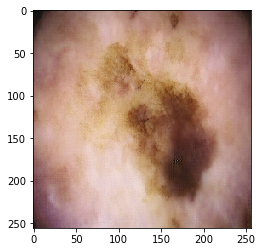

In [57]:
plt.imshow(predictions_MSKCC[0]/255.)

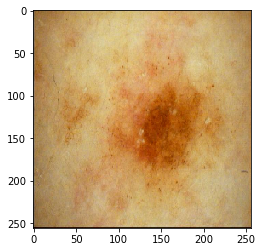

In [47]:
plt.imshow(dataB2[0]/255.)

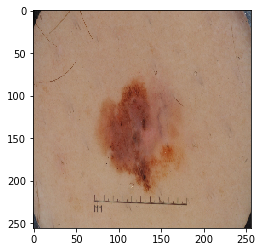

In [72]:
plt.imshow(dataA2[80]/255.)

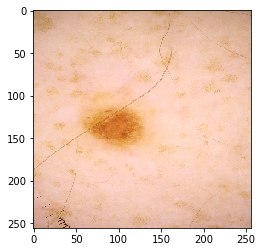

In [80]:
plt.imshow(np.rot90(dataA2[4]/255., k=3))
# np.rot90(dataA2/255., k=1, axes = (1,2)).shape

In [ ]:
# prediction = gen_function('gen_G', predictions_MSKCC)

In [33]:
load_model_BCN = tf.keras.models.load_model('models/cnn_melanoma_BCN_small_noweights_7.4.h5')

In [36]:
load_model_MSKCC = tf.keras.models.load_model('models/cnn_melanoma_MSKCC_small_noweights_7.4.h5')

In [37]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
#       tf.keras.metrics.SpecificityAtSensitivity(.82)
]
opt = tf.keras.optimizers.Adam(learning_rate = 1e-5 )#1e-5)

load_model_MSKCC.compile(loss='binary_crossentropy', metrics=METRICS,optimizer=opt)
# load_model_BCN.compile(loss='binary_crossentropy', metrics=METRICS,optimizer=opt)



In [38]:
def model_evaluate(image_array, ground_truth, model):
    tensor_predictions = tf.convert_to_tensor(image_array/255.)
    tensor_truth = tf.convert_to_tensor(ground_truth)
    model.evaluate(tensor_predictions, tensor_truth, batch_size = 1)

In [39]:
predictions_MSKCC = np.load('gen_G.6.npy')

# prediction_MSKCC_90 = np.load('gen_G.3_rot90.npy')
# prediction_MSKCC_180 = np.load('gen_G.3_rot180.npy')
# prediction_MSKCC_270 = np.load('gen_G.3_rot270.npy')

In [ ]:
predictions_BCN = np.load('gen_G.25.npy')

In [53]:
model_evaluate(predictions_BCN,testB_ground_truth, load_model_MSKCC )

136/136 [==============================] - 5s 18ms/step - loss: 0.9646 - tp: 6.0000 - fp: 16.0000 - tn: 86.0000 - fn: 28.0000 - accuracy: 0.6765 - precision: 0.2727 - recall: 0.1765 - auc: 0.5689 - prc: 0.3198


In [40]:
model_evaluate(predictions_MSKCC,testA_ground_truth, load_model_MSKCC )

2742/2742 [==============================] - 49s 16ms/step - loss: 0.1261 - tp: 14.0000 - fp: 91.0000 - tn: 2608.0000 - fn: 29.0000 - accuracy: 0.9562 - precision: 0.1333 - recall: 0.3256 - auc: 0.8652 - prc: 0.1158


In [30]:
rotate = np.rot90(dataA2, k=1, axes = (1,2))

# rotate = np.rot90(predictions_MSKCC, k=3, axes = (1,2))

In [25]:
model_evaluate(predictions_MSKCC,testA_ground_truth, load_model_MSKCC )

2742/2742 [==============================] - 49s 16ms/step - loss: 0.1803 - tp: 21.0000 - fp: 194.0000 - tn: 2505.0000 - fn: 22.0000 - accuracy: 0.9212 - precision: 0.0977 - recall: 0.4884 - auc: 0.8686 - prc: 0.0993


In [29]:
model_evaluate(dataB2,testB_ground_truth, load_model_MSKCC )

In [26]:
def model_predict(image_array, model):
    tensor_predictions = tf.convert_to_tensor(image_array/255.)
    CNN_model_predictions = model.predict(tensor_predictions)
    return CNN_model_predictions

In [ ]:
BCN_predictions_cycle =model_predict(predictions_MSKCC, load_model_BCN)

In [ ]:
BCN_predictions = model_predict(dataA2, load_model_BCN)

In [ ]:
# .squeeze()
test = BCN_predictions.squeeze()

In [27]:
import sklearn
from sklearn import metrics
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
#     plt.xlim([-0.5,20])
#     plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# plot_roc("Original Images",testA_ground_truth, BCN_predictions, color=colors[0])
# plot_roc("Cycled Images",testA_ground_truth, BCN_predictions_cycle, color=colors[1])


# plt.legend(loc='lower right')

In [28]:
# MSKCC_predictions_cycle =model_predict(predictions_BCN, load_model_MSKCC)
MSKCC_predictions_cycle =model_predict(prediction_MSKCC, load_model_MSKCC)
# MSKCC_predictions_cycle90 =model_predict(prediction_MSKCC_90, load_model_MSKCC)
# MSKCC_predictions_cycle180 =model_predict(prediction_MSKCC_180, load_model_MSKCC)
# MSKCC_predictions_cycle270 =model_predict(prediction_MSKCC_270, load_model_MSKCC)

In [77]:
rotate_img = np.rot90(predictions_MSKCC[1,:,:,:], k=3, axes = (0,1))
# rotate_img = np.rot90(dataA2[1,:,:,:], k=3, axes = (0,1))

load_model_MSKCC.predict(np.expand_dims(rotate_img/255., axis = 0))

array([[0.6744301]], dtype=float32)

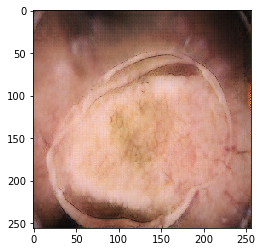

In [74]:
plt.imshow(rotate_img/255.)

In [57]:
csv_testA[csv_testA.image_dir == 'ISIC_0924427']

,image_dir,target
1,ISIC_0924427,1


In [29]:
# MSKCC_predictions = model_predict(dataB2, load_model_MSKCC)
rotate90 = np.rot90(dataA2, k=1, axes = (1,2))
rotate180 = np.rot90(dataA2, k=2, axes = (1,2))
rotate270 = np.rot90(dataA2, k=3, axes = (1,2))

MSKCC_predictions = model_predict(dataA2, load_model_MSKCC)
# MSKCC_predictions90 = model_predict(rotate90, load_model_MSKCC)
# MSKCC_predictions180 = model_predict(rotate180, load_model_MSKCC)
# MSKCC_predictions270 = model_predict(rotate270, load_model_MSKCC)

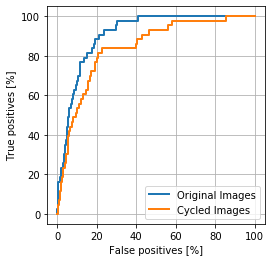

In [30]:
plot_roc("Original Images",testA_ground_truth, MSKCC_predictions, color=colors[0])
plot_roc("Cycled Images",testA_ground_truth, MSKCC_predictions_cycle, color=colors[1])
plt.legend(loc='lower right')

In [47]:
def threshold_predictions(predicted_array, ground_truth):
    copy_array = np.copy(predicted_array)
    copy_array[copy_array>=.5] = 1
    copy_array[copy_array<.5] = 0
    return copy_array

In [ ]:
threshold_predictions_original= threshold_predictions(MSKCC_predictions, testA_ground_truth)
threshold_predictions_cycled= threshold_predictions(MSKCC_predictions_cycle, testA_ground_truth)

In [48]:
def compare_missed(cyled_predicted, original_predicted, ground_truth, csv):
    thresholded_cycled= threshold_predictions(cyled_predicted, ground_truth)
    thresholded_original= threshold_predictions(original_predicted, ground_truth)


    csv_cycled_copy = csv.copy()
    csv_original_copy = csv.copy()

    
    thresholded_cycled_copy = thresholded_cycled.reshape(thresholded_cycled.shape[0])
    
    cyled_predicted_copy = np.copy(cyled_predicted)
    cyled_predicted_copy = cyled_predicted_copy[thresholded_cycled_copy != ground_truth]
    cyled_predicted_copy =  cyled_predicted_copy.reshape(cyled_predicted_copy.shape[0])
    
    thresholded_original_copy = thresholded_original.reshape(thresholded_original.shape[0])
    original_predicted_copy = np.copy(original_predicted)
    original_predicted_copy = original_predicted_copy[thresholded_original_copy != ground_truth]
    original_predicted_copy = original_predicted_copy.reshape(original_predicted_copy.shape[0])
    
    
    csv_cycled_copy = csv_cycled_copy[thresholded_cycled_copy != ground_truth]
    
    csv_original_copy = csv_original_copy[thresholded_original_copy != ground_truth]
    
    csv_cycled_copy['cycled_prediction'] = cyled_predicted_copy
    csv_original_copy['original_prediction'] = original_predicted_copy
    
    return csv_original_copy, csv_cycled_copy

In [49]:
def compare_missed_2(cyled_predicted, original_predicted, ground_truth, csv):
    thresholded_cycled= threshold_predictions(cyled_predicted, ground_truth)
    thresholded_original= threshold_predictions(original_predicted, ground_truth)


    csv_cycled_copy = csv.copy()
    csv_original_copy = csv.copy()

    
    thresholded_cycled_copy = thresholded_cycled.reshape(thresholded_cycled.shape[0])
    cyled_predicted_copy = np.copy(cyled_predicted)
    thresholded_original_copy = thresholded_original.reshape(thresholded_original.shape[0])
    original_predicted_copy = np.copy(original_predicted)
    
    if ((len(thresholded_cycled_copy != ground_truth)) >= (len(thresholded_original_copy != ground_truth))):
    
        cyled_predicted_copy = cyled_predicted_copy[thresholded_cycled_copy != ground_truth]
        cyled_predicted_copy =  cyled_predicted_copy.reshape(cyled_predicted_copy.shape[0])

        original_predicted_copy = original_predicted_copy[thresholded_cycled_copy != ground_truth]
        original_predicted_copy = original_predicted_copy.reshape(original_predicted_copy.shape[0])
        
        csv_cycled_copy = csv_cycled_copy[thresholded_cycled_copy != ground_truth]
    
        csv_original_copy = csv_original_copy[thresholded_cycled_copy != ground_truth]
        
    else:
        cyled_predicted_copy = cyled_predicted_copy[thresholded_original_copy != ground_truth]
        cyled_predicted_copy =  cyled_predicted_copy.reshape(cyled_predicted_copy.shape[0])
    
        original_predicted_copy = original_predicted_copy[thresholded_original_copy != ground_truth]
        original_predicted_copy = original_predicted_copy.reshape(original_predicted_copy.shape[0])
    
        csv_cycled_copy = csv_cycled_copy[thresholded_original_copy != ground_truth]
        csv_original_copy = csv_original_copy[thresholded_original_copy != ground_truth]
        
    
    csv_cycled_copy['cycled_prediction'] = cyled_predicted_copy
    csv_original_copy['original_prediction'] = original_predicted_copy
    
    return csv_original_copy, csv_cycled_copy

In [51]:
# csv_original_copy, csv_cycled_copy = compare_missed(MSKCC_predictions_cycle,MSKCC_predictions,testB_ground_truth, csv_testB )
# csv_original_copy, csv_cycled_copy = compare_missed(BCN_predictions_cycle,BCN_predictions,testA_ground_truth, csv_testA )
csv_original_copy, csv_cycled_copy = compare_missed(MSKCC_predictions_cycle,MSKCC_predictions,testA_ground_truth, csv_testA )




In [52]:
# predictions_csv = csv_testA.copy()

# predictions_csv['original_prediction'] = BCN_predictions
# predictions_csv['cycled_prediction'] = BCN_predictions_cycle
# predictions_csv['difference_value'] = -1* (predictions_csv['original_prediction']- predictions_csv['cycled_prediction'])

# predictions_csv = csv_testB.copy()
predictions_csv = csv_testA.copy()


predictions_csv['original_prediction'] = MSKCC_predictions
predictions_csv['cycled_prediction'] = MSKCC_predictions_cycle
predictions_csv['difference_value'] = -1* (predictions_csv['original_prediction']- predictions_csv['cycled_prediction'])

In [53]:
predictions_csv.reset_index(inplace = True)

In [74]:
# predictions_csv[(predictions_csv['difference_value'] < 0) & (predictions_csv['target'] == 1) & (predictions_csv['cycled_prediction'] < 0.5) & (predictions_csv['original_prediction'] >= 0.5)].shape

predictions_csv[(predictions_csv['target'] == 1) & (predictions_csv['cycled_prediction'] < 0.5) & (predictions_csv['original_prediction'] < 0.5)]['difference_value'].mean()



-0.14179005

In [ ]:
dataframe = pd.merge(csv_cycled_copy, csv_original_copy, how = 'left', left_on = 'image_dir', right_on = 'image_dir', left_index=True)


In [ ]:
dataframe['difference_value'] = abs(dataframe['original_prediction']- dataframe['cycled_prediction'])

In [ ]:
dataframe['difference_value'].mean()

In [ ]:
dataframe.index

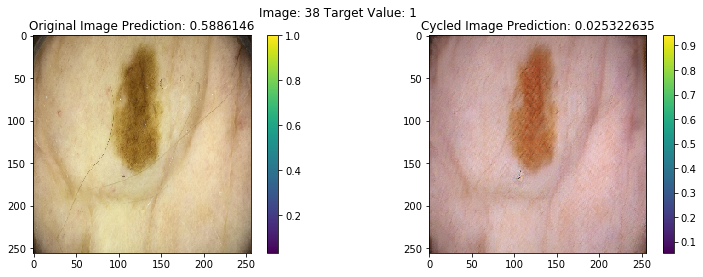

In [85]:
# plt.imshow(predictions_MSKCC[0,:,:,:]/255.)
# plt.title("test")
#plt.imshow(dataA2[0,:,:,:]/255.)

def show_image_prediction(i):
    fig, (ax1, ax2) = plt.subplots(figsize=(13, 4), ncols=2)
    pos1 = ax1.imshow(dataA2[i,:,:,:]/255.)
    fig.colorbar(pos1, ax=ax1)
    ax1.set_title('Original Image Prediction: ' + str(predictions_csv['original_prediction'][i]) )

    pos2 = ax2.imshow(predictions_MSKCC[i,:,:,:]/255.)
    fig.colorbar(pos2, ax=ax2)
    ax2.set_title('Cycled Image Prediction: '+ str(predictions_csv['cycled_prediction'][i]))
#     print("Target Value: " + str(dataframe['target_x'][i]))
    fig.suptitle("Image: " + str(i) + " Target Value: " + str(predictions_csv['target'][i]))

show_image_prediction(38)



In [ ]:
plt.figure(figsize=(20,8))
fig, (ax1, ax2) = plt.subplots(2,1, sharey=False, figsize=(20,20))
ax1.scatter(dataframe.index.to_numpy(), dataframe['cycled_prediction'],  label ='Cycled_images')
ax1.scatter(dataframe.index.to_numpy(), dataframe['original_prediction'], color = 'Maroon', label = 'Original_images')
ax1.scatter(dataframe.index.to_numpy(), dataframe['target_x'], color = 'Green', label = 'Ground_truth')
#plt.plot(dataframe['image_dir'][0:66],dataframe['target_x'][0:66], color = 'green')
# plt.plot(dataframe['image_dir'][0:66],dataframe['difference_value'][0:66], color = 'orange')
ax1.axhline(y=0.5, color='orange', linestyle='-')
ax1.legend()

ax1 = plt.gca()
ax1.axes.xaxis.set_visible(False)
ax1.axes.yaxis.set_visible(True)

x = dataframe.index.to_numpy()#dataframe['image_dir'].to_numpy(dtype=str)
y = dataframe['original_prediction'].to_numpy(dtype=float)
c = dataframe['cycled_prediction'].to_numpy(dtype=float)
v = -dataframe['difference_value'].to_numpy(dtype=float)
#ax.arrow(x, y, 0, -dataframe['difference_value'].to_numpy() , color = 'grey', alpha = .5)
ax2.plot(x, y-c, color = 'purple')
plt.show()


In [ ]:
csv_testA_copy = csv_testA.copy()

In [ ]:
threshold_predictions_original_copy = threshold_predictions_original.reshape(2221)

In [ ]:
BCN_predictions_copy = np.copy(BCN_predictions)

In [ ]:
BCN_predictions_copy = BCN_predictions_copy[threshold_predictions_original_copy != testA_ground_truth]

In [ ]:
BCN_predictions_copy.shape

In [ ]:
BCN_predictions_copy.reshape(61)

In [ ]:
csv_testA_copy = csv_testA_copy[threshold_predictions_original_copy != testA_ground_truth]
csv_testA_copy['Prediction'] = BCN_predictions_copy

In [ ]:
csv_testA_copy

In [ ]:
plt.figure(figsize=(20,8))
plt.scatter(csv_testA['image_dir'][0:25], BCN_predictions_cycle[0:25],  label ='Cycled_images')
plt.scatter(csv_testA['image_dir'][0:25], BCN_predictions[0:25], color = 'Maroon', label = 'Original_images')
plt.scatter(csv_testA['image_dir'][0:25], testA_ground_truth[0:25], color = 'Green', label = 'Ground_truth')

plt.axhline(y=0.5, color='orange', linestyle='-')
plt.legend()

ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(True)

plt.show()

In [ ]:
test = BCN_predictions_cycle.reshape(2221,)
test2 =  BCN_predictions.reshape(2221,)

In [ ]:
# plt.figure(figsize=(15,12))
# plt.bar(csv_testA['image_dir'], BCN_predictions_cycle, label ='Cycle_images')

In [ ]:
# model_evaluate(predictions_BCN,testB_ground_truth, load_model_MSKCC )

In [ ]:
# model_evaluate(dataB2,testB_ground_truth, load_model_MSKCC )

In [ ]:
# load_model.evaluate(MSKCC_data_test)

In [ ]:
no_cycle_MSKCC = load_model.predict(tensor_true)

In [ ]:
cycled_MSKCC = load_model.predict(tensor_prediction)

In [ ]:
no_cycle_MSKCC[no_cycle_MSKCC>.5] = 1
no_cycle_MSKCC[no_cycle_MSKCC<.5] = 0

cycled_MSKCC[cycled_MSKCC>.5] = 1
cycled_MSKCC[cycled_MSKCC<.5] = 0

In [ ]:
2102/cycled_MSKCC.flatten().shape[0]

In [ ]:
np.sum(cycled_MSKCC == no_cycle_MSKCC)

In [ ]:
plt.imshow(prediction)

In [ ]:
# plt.imshow(dataB1[0,:,:,:]/255.)
original_A = np.zeros((4,256,256,3))
fake_B = np.zeros((4,256,256,3))

original_B = np.zeros((4,256,256,3))
fake_A = np.zeros((4,256,256,3))

In [ ]:
plt.imshow(predictions_BCN[0,:,:,:]/255.)

In [ ]:
plt.imshow(dataB2[0,:,:,:]/255.)

In [ ]:
_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, img in enumerate(testA_data.take(4)):
    prediction = cycle_gan_model.gen_F(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    
    original_A[i,:,:,:] = img
    fake_B[i,:,:,:] = prediction
    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input image")
    ax[i, 0].set_title("Input image")
    ax[i, 1].set_title("Translated image")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

    prediction = keras.preprocessing.image.array_to_img(prediction)
    prediction.save("predicted_BCN/predicted_img_{i}.jpg".format(i=i))
plt.tight_layout()
plt.show()

In [ ]:
_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, img in enumerate(testB_data.take(4)):
    prediction = cycle_gan_model.gen_G(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    
    original_B[i,:,:,:] = img
    fake_A[i,:,:,:] = prediction
    
    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input image")
    ax[i, 0].set_title("Input image")
    ax[i, 1].set_title("Translated image")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

    prediction = keras.preprocessing.image.array_to_img(prediction)
    prediction.save("predicted_MSKCC/predicted_img_{i}.jpg".format(i=i))
    
plt.tight_layout()
plt.show()

In [ ]:
# for i, img in enumerate(trainB_dataset.take(1)):
#     img= np.expand_dims(img, axis = 0)
#     print((img / 127.5) - 1.0)

In [ ]:
# tf.reduce_mean(fake_B[0, :, :, 1]/255.)
fake_B_color = [tf.reduce_mean(fake_B[:, :, :, 0]/255.).numpy(), tf.reduce_mean(fake_B[:, :, :, 1]/255.).numpy(), tf.reduce_mean(fake_B[:, :, :, 2]/255.).numpy()]
real_A_color = [tf.reduce_mean(original_A[0, :, :, 0]/255.).numpy(), tf.reduce_mean(original_A[0, :, :, 1]/255.).numpy(), tf.reduce_mean(original_A[0, :, :, 2]/255.).numpy()]

real_B_color = [tf.reduce_mean(original_B[0, :, :, 0]/255.).numpy(), tf.reduce_mean(original_B[0, :, :, 1]/255.).numpy(), tf.reduce_mean(original_B[0, :, :, 2]/255.).numpy()]

fake_A_color = [tf.reduce_mean(fake_A[0, :, :, 0]/255.).numpy(), tf.reduce_mean(fake_A[0, :, :, 1]/255.).numpy(), tf.reduce_mean(fake_A[0, :, :, 2]/255.).numpy()]

data_A_color = [tf.reduce_mean(dataA2[0, :, :, 0]/255.).numpy(), tf.reduce_mean(dataA2[0, :, :, 1]/255.).numpy(), tf.reduce_mean(dataA2[0, :, :, 2]/255.).numpy()]

data_B_color = [tf.reduce_mean(dataB2[0, :, :, 0]/255.).numpy(), tf.reduce_mean(dataB2[0, :, :, 1]/255.).numpy(), tf.reduce_mean(dataB2[0, :, :, 2]/255.).numpy()]



In [ ]:
data_BCN_color = [tf.reduce_mean(predictions_BCN[0, :, :, 0]/255.).numpy(), tf.reduce_mean(predictions_BCN[0, :, :, 1]/255.).numpy(), tf.reduce_mean(predictions_BCN[0, :, :, 2]/255.).numpy()]



In [ ]:
data_B_color = [tf.reduce_mean(dataA1[0, :, :, 0]/255.).numpy(), tf.reduce_mean(dataA1[0, :, :, 1]/255.).numpy(), tf.reduce_mean(dataA1[0, :, :, 2]/255.).numpy()]



In [ ]:
plt.hist((dataA1[:, :, :, :]/255.).ravel(), bins=256, range=(0.0, 1.0), facecolor=data_B_color) #calculating histogram



In [ ]:
plt.hist((predictions_BCN[:, :, :, :]/255.).ravel(), bins=256, range=(0.0, 1.0), facecolor=data_BCN_color) #calculating histogram



In [ ]:
_, ax = plt.subplots(3, 2, figsize=(15, 10))
ax[0, 0].hist((original_A[:, :, :, :]/255.).ravel(), bins=256, range=(0.0, 1.0), facecolor=real_A_color) #calculating histogram
ax[0, 0].set_title('Real A')
ax[0, 1].hist((original_B[:, :, :, :]/255.).ravel(), bins=256, range=(0.0, 1.0), facecolor=real_B_color) #calculating histogram
ax[0, 1].set_title('Real B')

ax[1, 1].hist((fake_A[:, :, :, :]/255.).ravel(), bins=256, range=(0.0, 1.0), facecolor=fake_A_color) #calculating histogram
ax[1, 1].set_title('Fake A')
ax[1, 0].hist((fake_B[:, :, :, :]/255.).ravel(), bins=256, range=(0.0, 1.0), facecolor=fake_B_color) #calculating histogram
ax[1, 0].set_title('Fake B')

ax[2, 0].hist((dataB2[:, :, :, :]/255.).ravel(), bins=256, range=(0.0, 1.0), facecolor=data_B_color) #calculating histogram
ax[2, 0].set_title('Dataset B')
ax[2, 1].hist((dataA2[:, :, :, :]/255.).ravel(), bins=256, range=(0.0, 1.0), facecolor=data_A_color) #calculating histogram
ax[2, 1].set_title('Dataset A')



plt.axis()